In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%pip install dfply
from dfply import *
%pip install pingouin
from pingouin import ancova
import statsmodels.api as sm
from statsmodels.formula.api import ols

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [66]:
df = pd.read_csv("/Users/yunfanliu/Desktop/INF2178_A3_data.csv")#read the data with currect path
df.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


In [67]:
df.shape #check the shape of raw data

(11933, 9)

In [68]:
df=df.drop(['totalhouseholdincome','incomeinthousands'],axis=1)
# Add reading and math scores change over time
df['math_over_time'] = df['springmathscore'] - df['fallmathscore']
df['reading_over_time'] = df['springreadingscore'] - df['fallreadingscore']
df.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,incomegroup,math_over_time,reading_over_time
0,36.58,39.54,33.822,49.37,50.10,40.533,3,10.56,12.79
1,50.82,44.44,38.147,83.50,58.93,37.409,3,14.49,32.68
2,40.68,28.57,28.108,40.41,32.81,29.312,3,4.24,-0.27
3,32.57,23.57,15.404,34.14,35.25,27.382,2,11.68,1.57
4,31.98,19.65,18.727,32.84,23.60,26.977,2,3.95,0.86


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fallreadingscore             11933 non-null  float64
 1   fallmathscore                11933 non-null  float64
 2   fallgeneralknowledgescore    11933 non-null  float64
 3   springreadingscore           11933 non-null  float64
 4   springmathscore              11933 non-null  float64
 5   springgeneralknowledgescore  11933 non-null  float64
 6   incomegroup                  11933 non-null  int64  
 7   math_over_time               11933 non-null  float64
 8   reading_over_time            11933 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 839.2 KB


Based on the statistical summary of the data

- The dataset has a total of 11933 entries with 9 features .
- One feature is recognized as integer type (int64) and 8 features are recognized as float types
- There are no significant missing values as each feature has 11933 non-null values.

# Math Over Time

## EDA

In [70]:
# summary statistics for dependent variable yield
df >> group_by(X.incomegroup) >> summarize(n=X['math_over_time'].count(), mean=X['math_over_time'].mean(), std=X['math_over_time'].std())

,incomegroup,n,mean,std
0,1,4729,9.958547,6.406540
1,2,3726,10.896224,6.853736
2,3,3478,11.399178,7.339003


As the income group increases from 1 to 3, there is also an increase in the average improvement of students' math scores over time. The average increase for Group 1 is about 9.96 points, for Group 2 it is 10.90 points, and for Group 3 it is 11.40 points. Accompanying this trend is an increase in standard deviation, from 6.41 in Group 1 to 7.34 in Group 3, which indicates a greater variability in the improvement of math scores among students in higher income groups.

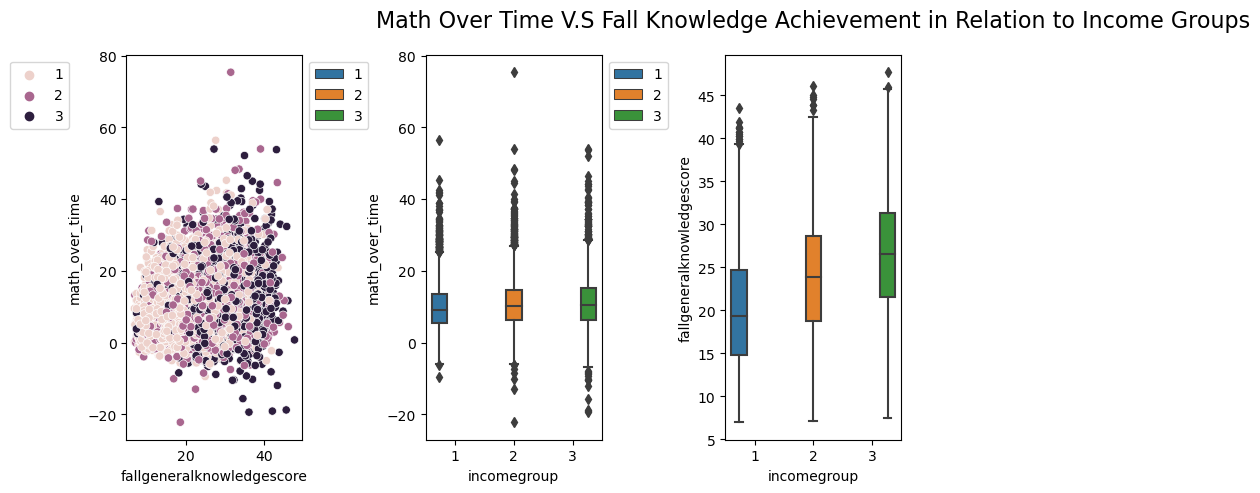

In [71]:
# creating multiple subgraphs
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.7, hspace=0.5)
sns.scatterplot(data=df, x="fallgeneralknowledgescore", y="math_over_time", hue=df.incomegroup.tolist(), ax=axs[0])
sns.boxplot(data=df, x="incomegroup", y="math_over_time", hue=df.incomegroup.tolist(), ax=axs[1])
sns.boxplot(data=df, x="incomegroup", y="fallgeneralknowledgescore", hue=df.incomegroup.tolist(), ax=axs[2])
axs[0].legend( bbox_to_anchor=(-0.7, 1), loc=2)
axs[1].legend( bbox_to_anchor=(-0.7, 1), loc=2)
axs[2].legend( bbox_to_anchor=(-0.7, 1), loc=2)
plt.title("Math Over Time V.S Fall Knowledge Achievement in Relation to Income Groups",fontsize=16,y=1.05)
plt.subplots_adjust()
plt.show()

Scatter Plot: Displays the relationship between students’ general knowledge scores in the fall and the change in math scores over time, with different colors representing different income groups. The plot indicates a positive correlation between students' fall general knowledge scores and their subsequent improvement in math scores over time.

Box Plot (Middle): Compares the income groups with the changes in math scores over time, showing that students from higher-income groups tend to have a larger median change in math scores. As income groups increase, variability also appears to increase.

Box Plot (Right): Shows the distribution of fall general knowledge scores across different income groups. Students from higher-income groups have higher median general knowledge scores. This may suggest that students from higher-income families have access to better educational resources.

Additionally, the charts contain a significant number of outliers, which I have decided to keep. Removing them could lead to a misunderstanding of the overall data structure and distribution, whereas retaining them ensures the integrity of the data.

## ANCOVA

The effect of income group on the change in math scores:

H0: The average change in math scores is equal across all income groups, which means the income group does not have an effect on the change in students' math scores.

H1: There is at least one income group whose average change in math scores is different from the others, suggesting that the income group does influence the change in students' math scores.

The effect of fall general knowledge scores as a covariate:

H0: There is no relationship between fall general knowledge scores and the change in math scores.

H1: There is a relationship between fall general knowledge scores and the change in math scores.

In [72]:
#ancova 
ancova_results = ancova(data=df, dv='math_over_time', covar='fallgeneralknowledgescore', between='incomegroup')

#retain two decimal places
#adjust p-value
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"
ancova_results_rounded = ancova_results.round(2)  
ancova_results_rounded['p-unc'] = ancova_results_rounded['p-unc'].apply(lambda p: format_pvalue(p))


ancova_results_rounded

,Source,SS,DF,F,p-unc,np2
0,incomegroup,55.88,2,0.62,0.540,0.00
1,fallgeneralknowledgescore,22425.93,1,501.08,<0.001,0.04
2,Residual,533880.50,11929,NaN,nan,NaN


For the independent variable, income group, the impact on the change in math scores over time was found to be F = 0.62 with a p-value = 0.540 > 0.05, indicating that we cannot reject the null hypothesis, i.e.the average change in math scores is equal across all income groups, which means the income group does not have an effect on the change in students' math scores.

For the covariate, fall general knowledge score , the impact on the change in math scores over time was significant with F = 501.08 and a p-value < 0.001, suggesting that there is sufficient evidence to reject the null hypothesis,i.e.there is no relationship between fall general knowledge scores and the change in math scores.

In [73]:
#ancova using statsmodels
model = ols('math_over_time ~ incomegroup + fallgeneralknowledgescore', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         math_over_time   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     299.9
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          8.33e-128
Time:                        16:28:38   Log-Likelihood:                -39610.
No. Observations:               11933   AIC:                         7.923e+04
Df Residuals:                   11930   BIC:                         7.925e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

The results indicate that the coefficient for the income group is 0.0752, with a p-value of 0.347>0.05, suggesting that we cannot reject the null hypothesis,i.e.the average change in math scores is equal across all income groups, which means the income group does not have an effect on the change in students' math scores. 

The coefficient for fall general knowledge scores is 0.1996, with a p-value<0.001, indicating that there is sufficient evidence to reject the null hypothesis i.e.there is no relationship between fall general knowledge scores and the change in math scores, and there is a significant positive correlation between fall general knowledge scores and the change in math scores.

The R-squared value is 0.048, suggesting that the variables in the model explain only about 4.8% of the variability in the change in math scores. This implies that there are other factors not included in the model that are affecting the change in math scores.
The Omnibus test's p-value is close to 0, indicating that the residuals may not be normally distributed.

H0 : There is no interaction between income group and fall general knowledge scores, meaning their impacts on the change in math scores are independent of each other.

H1: There is an interaction between income group and fall general knowledge scores, meaning they jointly influence the change in math scores.

In [74]:
# Fit ANCOVA model with interaction term
model_interaction = sm.formula.ols('math_over_time ~ incomegroup * fallgeneralknowledgescore', data=df).fit()
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:         math_over_time   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     206.9
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          7.97e-131
Time:                        16:28:39   Log-Likelihood:                -39600.
No. Observations:               11933   AIC:                         7.921e+04
Df Residuals:                   11929   BIC:                         7.924e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The coefficient for the income groupis 1.1572, with a p-value < 0.001, indicating that we have sufficient evidence to reject  the null hypothesis that the average change in math scores is the same across all income groups.

The coefficient for the fall general knowledge scoreis 0.2889, with a p-value < 0.001, indicating that we have sufficient evidence to reject the null hypothesis that there is no relationship between fall general knowledge scores and the change in math scores.


The coefficient for the interaction term incomegroup:fallgeneralknowledgescore is -0.0464, with a p-value < 0.001, indicating that we have sufficient evidence to reject the null hypothesis that there is no interaction between income group and fall general knowledge scores.


# Reading Over Time

## EDA

In [75]:
# summary statistics for dependent variable yield
df >> group_by(X.incomegroup) >> summarize(n=X['reading_over_time'].count(), mean=X['reading_over_time'].mean(), std=X['reading_over_time'].std())

,incomegroup,n,mean,std
0,1,4729,10.878279,7.462176
1,2,3726,11.716932,7.906122
2,3,3478,12.308387,8.967606


As the income group increases from 1 to 3, there is also an increase in the average improvement of students' reading scores over time. The average increase for Group 1 is about 10.88 points, for Group 2 it is 11.72 points, and for Group 3 it is 12.30 points. Accompanying this trend is an increase in standard deviation, from 7.46 in Group 1 to 8.97 in Group 3, which indicates a greater variability in the improvement of reading scores among students in higher income groups.

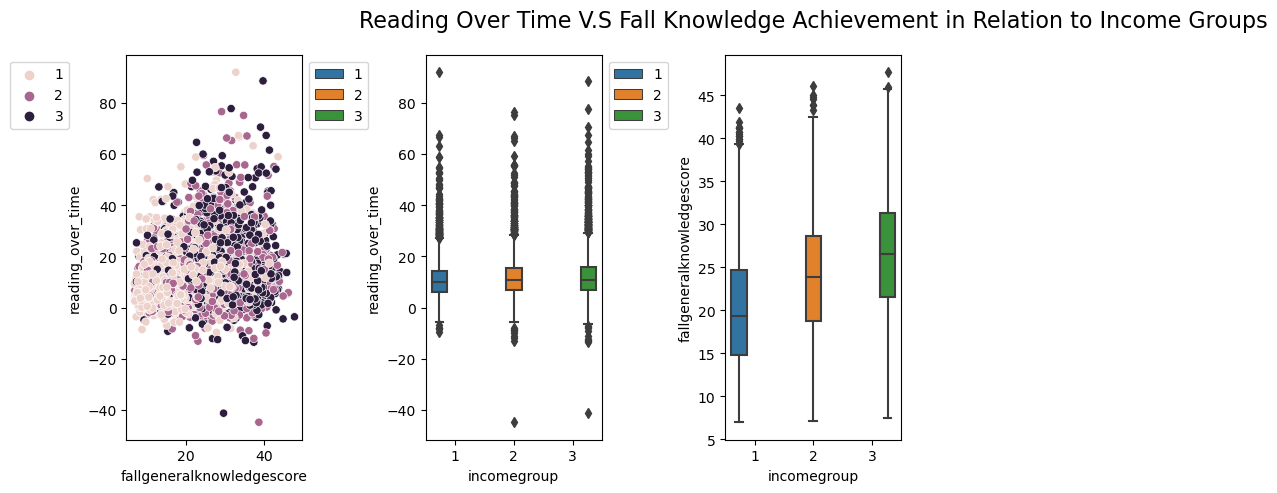

In [76]:
# creating multiple subgraphs
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.7, hspace=0.5)
sns.scatterplot(data=df, x="fallgeneralknowledgescore", y="reading_over_time", hue=df.incomegroup.tolist(), ax=axs[0])
sns.boxplot(data=df, x="incomegroup", y="reading_over_time", hue=df.incomegroup.tolist(), ax=axs[1])
sns.boxplot(data=df, x="incomegroup", y="fallgeneralknowledgescore", hue=df.incomegroup.tolist(), ax=axs[2])
axs[0].legend( bbox_to_anchor=(-0.7, 1), loc=2)
axs[1].legend( bbox_to_anchor=(-0.7, 1), loc=2)
axs[2].legend( bbox_to_anchor=(-0.7, 1), loc=2)
plt.title("Reading Over Time V.S Fall Knowledge Achievement in Relation to Income Groups",fontsize=16,y=1.05)
plt.subplots_adjust()
plt.show()

Scatter Plot: Displays the relationship between students’ general knowledge scores in the fall and the change in reading scores over time, with different colors representing different income groups. The plot indicates a positive correlation between students' fall general knowledge scores and their subsequent improvement in reading scores over time.

Box Plot (Middle): Compares the income groups with the changes in reading scores over time, showing that students from higher-income groups tend to have a larger median change in reading scores. As income groups increase, variability also appears to increase.

Box Plot (Right): Shows the distribution of fall general knowledge scores across different income groups. Students from higher-income groups have higher median general knowledge scores. This may suggest that students from higher-income families have access to better educational resources.

Additionally, the charts contain a significant number of outliers, which I have decided to keep. Removing them could lead to a misunderstanding of the overall data structure and distribution, whereas retaining them ensures the integrity of the data.

## ANCOVA

The effect of income group on the change in reading scores:

H0: The average change in reading scores is equal across all income groups, which means the income group does not have an effect on the change in students' reading scores.

H1: There is at least one income group whose average change in reading scores is different from the others, suggesting that the income group does influence the change in students' reading scores.

The effect of fall general knowledge scores as a covariate:

H0: There is no relationship between fall general knowledge scores and the change in reading scores.

H1: There is a relationship between fall general knowledge scores and the change in reading scores.

In [77]:
#ancova 
ancova_results = ancova(data=df, dv='reading_over_time', covar='fallgeneralknowledgescore', between='incomegroup')

#retain two decimal places
#adjust p-value
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"
ancova_results_rounded = ancova_results.round(2)  
ancova_results_rounded['p-unc'] = ancova_results_rounded['p-unc'].apply(lambda p: format_pvalue(p))


ancova_results_rounded

,Source,SS,DF,F,p-unc,np2
0,incomegroup,287.49,2,2.25,0.110,0.00
1,fallgeneralknowledgescore,14054.12,1,220.11,<0.001,0.02
2,Residual,761671.04,11929,NaN,nan,NaN


For the independent variable, income group, the impact on the change in reading scores over time was found to be F = 2.25 with a p-value = 0.110 > 0.05, indicating that we cannot reject the null hypothesis, i.e.the average change in reading scores is equal across all income groups, which means the income group does not have an effect on the change in students' reading scores.

For the covariate, fall general knowledge score , the impact on the change in reading scores over time was significant with F = 220.11 and a p-value < 0.001, suggesting that there is sufficient evidence to reject the null hypothesis,i.e.there is no relationship between fall general knowledge scores and the change in reading scores.

In [78]:
#ancova using statsmodels
model = ols('reading_over_time ~ incomegroup + fallgeneralknowledgescore', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      reading_over_time   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     143.2
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           3.35e-62
Time:                        16:28:45   Log-Likelihood:                -41730.
No. Observations:               11933   AIC:                         8.347e+04
Df Residuals:                   11930   BIC:                         8.349e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

For the income group incomegroup, the coefficient is 0.2025 with a p-value=0.034<0.05. This means we have sufficient evidence to reject the null hypothesis, i.e. the average change in reading scores is equal across all income groups, which means the income group does not have an effect on the change in students' reading scores.

For the fall general knowledge score , the coefficient is 0.1578 with a p-value<0.001, indicating that we have sufficient evidence to reject the null hypothesis i.e. there is no relationship between fall general knowledge scores and the change in reading scores, and it demonstrates that the fall general knowledge score has a significant positive impact on the change in reading scores.

The R-squared value is 0.023, indicating that these variables only explain approximately 2.3% of the variability in the change in reading scores. This suggests that there are many other factors that may affect the change in reading scores.
The Omnibus test's p-value is close to 0, suggesting that the residuals may not follow a normal distribution.

H0 : There is no interaction between income group and fall general knowledge scores, meaning their impacts on the change in reading scores are independent of each other.

H1: There is an interaction between income group and fall general knowledge scores, meaning they jointly influence the change in reading scores.

In [79]:
# Fit ANCOVA model with interaction term
model_interaction = sm.formula.ols('reading_over_time ~ incomegroup * fallgeneralknowledgescore', data=df).fit()
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:      reading_over_time   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     102.8
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           1.10e-65
Time:                        16:28:46   Log-Likelihood:                -41720.
No. Observations:               11933   AIC:                         8.345e+04
Df Residuals:                   11929   BIC:                         8.348e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The coefficient for the income groupis 1.5409, with a p-value < 0.001, indicating that we have sufficient evidence to reject the null hypothesis that the average change in reading scores is the same across all income groups. 

The coefficient for the fall general knowledge scoreis 0.2683, with a p-value < 0.001, indicating that we have sufficient evidence to reject  the null hypothesis that there is no relationship between fall general knowledge scores and the change in reading scores.

The coefficient for the interaction term incomegroup:fallgeneralknowledgescore is -0.0575, with a p-value < 0.001, indicating that we have sufficient evidence to reject the null hypothesis that there is no interaction between income group and fall general knowledge scores. 